In [47]:
import matplotlib.pyplot as plt
import numpy as np
import dsdl
import numpy.random
from typing import Callable, List
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
DATASETS = ['a1a', 'mushrooms', 'a6a', 'w1a', 'w5a', 'ionosphere']
METHODS = ['SGD', 'AdaSpider', 'Spider', 'SpiderBoost', 'SVRG', 'AdaGrad', 'AdaSVRG']

# Logistic regression

In [49]:
from src.optimizers.Optimizer import Optimizer

In [55]:
def get_data(dataset_name: str):
    """
    :param dataset_name: Name of the dataset from dsdl module.
    :return: (X, y) train and target data.
    """
    ds = dsdl.load(dataset_name)
    X, y = ds.get_train()
    X = X.toarray()
    y = y.reshape(-1, 1)
    return X, y

def build_model(X, y):
    """
    Builds
    :param X: shape=(N, D). Train data
    :param y: shape=(N, 1). Target data
    :return: shape=(N, D+1). Built model for logistic regression.
    """
    return np.c_[np.ones((y.shape[0], 1)), X]

def get_initial_weights(tx):
    """
    Returns weights initialized from the uniform distribution [0, 1].
    :param tx: shape=(N, D). Build model
    :return: shape=(D, 1) Initial weights
    """
    np.random.seed(2022)
    return np.ones(shape=(tx.shape[1], 1))  # low=0, high=1,

def test_method(method: Optimizer,
                initial_weights,
                tx,
                y,
                max_iter: int,
                *parameter):
        """
        :param method: Optimization method implementation from src optimizers module.
        :param dataset_name: Name of the dataset from dsdl module.
        :param max_iter: Number of iterations to test.
        :param parameters optional: Dataclass containing parameters used int optimization method.
        :return: List of gradients from optimization method.
        """
        gradients, loss = method.optimize(initial_weights, tx, y, max_iter)
        return [np.linalg.norm(grad, 2) for grad in gradients], loss

In [56]:
from src.optimizers.SGD import SGD
from src.optimizers.AdaSpider import AdaSpider
from src.optimizers.Spider import Spider
from src.optimizers.SpiderBoost import SpiderBoost
from src.optimizers.SVRG import SVRG
from src.optimizers.AdaGrad import AdaGrad
from src.optimizers.AdaSVRG import AdaSVRG

In [53]:
N_ORACLE_CALLS = 100

METHODS = [
    SGD(lambda_=0.01, q=N_ORACLE_CALLS),
    AdaSpider(q=N_ORACLE_CALLS),
    Spider(n_0 = 1, epsilon=0.01, q=N_ORACLE_CALLS),
    SpiderBoost(q=N_ORACLE_CALLS),
    SVRG(lambda_=0.001, q=N_ORACLE_CALLS),
    AdaGrad(lambda_=0.5, epsilon= 0.00001, q=N_ORACLE_CALLS),
    AdaSVRG(lambda_=0.1, q=N_ORACLE_CALLS)
]

### Plot

Dataset a1a
Method SGD


ValueError: too many values to unpack (expected 2)

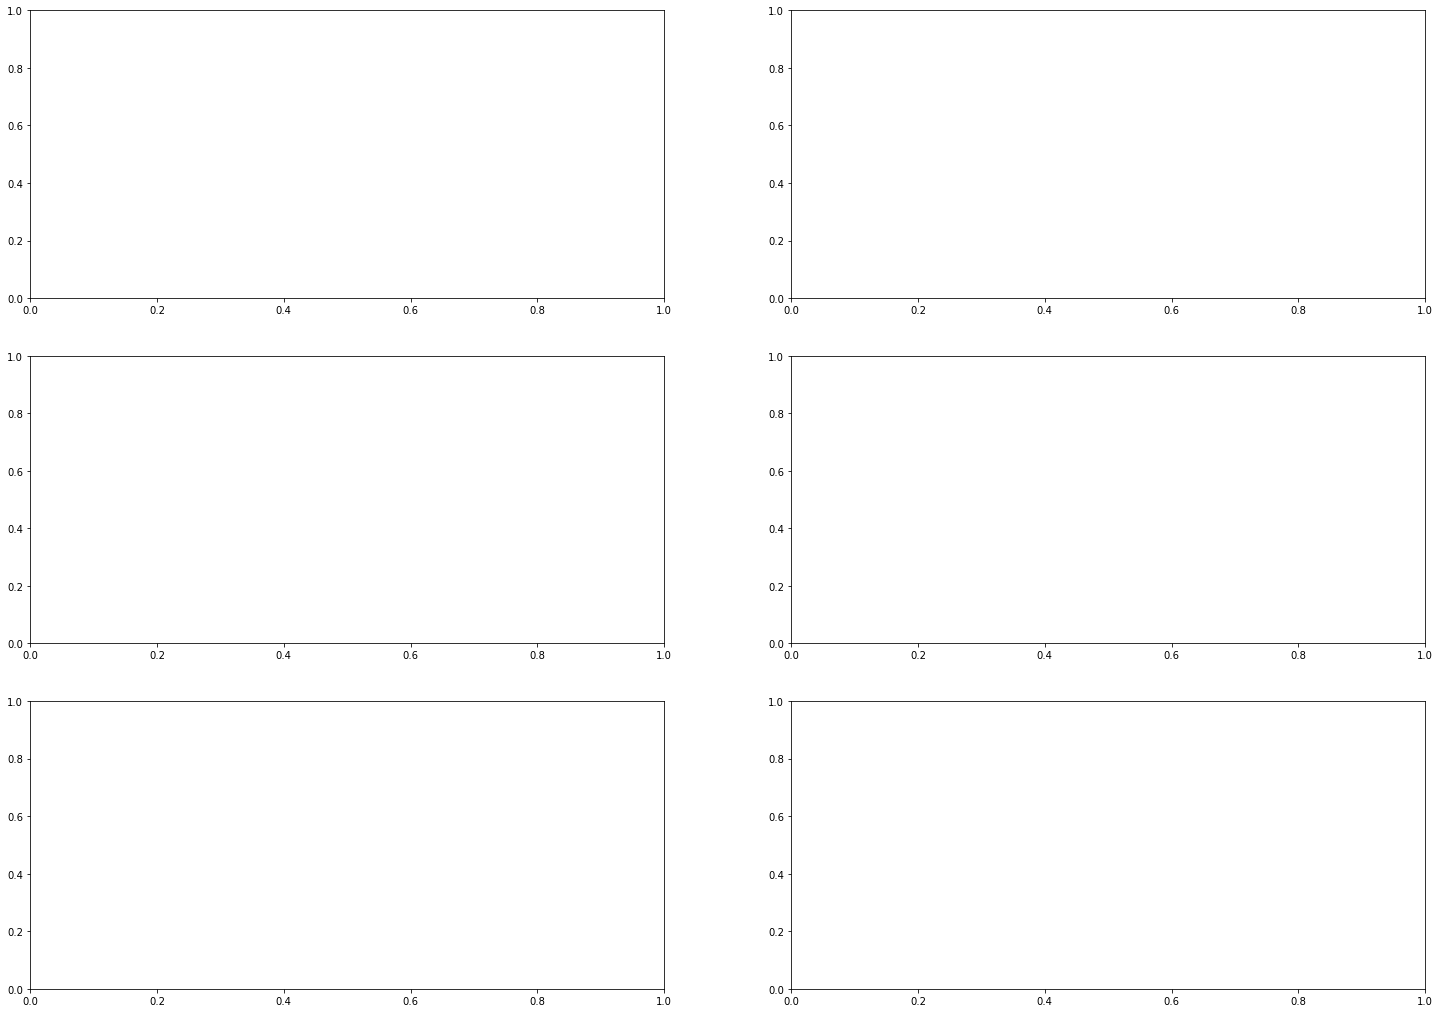

In [54]:
ITERATIONS = 1000
N_TESTS = 1

# def plot_data():
# Write your code to make 4x4 panel here
X_LABEL = "Stochastic oracle calls"
Y_LABEL = "||\u0394f(x)||^2"

fig, ax = plt.subplots(3, 2, figsize=(25, 18), sharey=False, sharex=False)

for i, dataset_name in enumerate(DATASETS):

    print("Dataset", dataset_name)
    sbplt = ax[i%3, i%2]

    X, y = get_data(dataset_name)
    tx = build_model(X, y)
    initial_weights = get_initial_weights(tx)

    for method in METHODS:
        print("Method", method.name)
        gradients_5_runs = list()
        losses_runs = list()
        for _ in range(N_TESTS):
            gradients, losses = test_method(method, initial_weights, tx, y, ITERATIONS)
            gradients_5_runs.append(gradients)
        gradients_mean = np.mean(gradients_5_runs, axis=0)

        stddev = np.std(gradients_5_runs, axis=0)
        lower = gradients_mean - stddev
        upper = gradients_mean + stddev

        sbplt.plot(gradients_mean, label=method.name)
        sbplt.fill_between(list(range(len(gradients_mean))), lower, upper, alpha=0.25,
                           facecolor='red', edgecolor='red')

    sbplt.set_xscale('log')
    sbplt.set_title(dataset_name)
    sbplt.set_xlabel(X_LABEL)
    sbplt.set_ylabel(Y_LABEL)
    sbplt.legend(loc='lower left')

    break  # plot single dataset

fig.tight_layout(pad=2.0)
fig.savefig('tests_logistic_regression.jpg', dpi=300)

# plot_data()

Do parameter sweep

In [35]:
from itertools import product

In [71]:
REDUCTION_STEP = 100

METHODS = [
    SGD(lambda_=0.01, q=REDUCTION_STEP),
    AdaSpider(q=REDUCTION_STEP),
    Spider(n_0 = 1, epsilon=0.01, q=REDUCTION_STEP),
    SpiderBoost(q=REDUCTION_STEP),
    SVRG(lambda_=0.001, q=REDUCTION_STEP),
    AdaGrad(lambda_=0.5, epsilon= 0.00001, q=REDUCTION_STEP),
    AdaSVRG(lambda_=0.1, q=REDUCTION_STEP)
]

DF_COLUMNS = ['method_name', 'loss', 'parameters']
df = pd.DataFrame(columns=DF_COLUMNS)

dataset_name = 'a1a'
ITERATIONS = 5000
print("Dataset", dataset_name, "Iterations: ", ITERATIONS)

powers = np.array([range(-5, 0)], dtype=float)
parameters = 10**powers.flatten()

X, y = get_data(dataset_name)
tx = build_model(X, y)
initial_weights = get_initial_weights(tx)

for method in METHODS:
    print("Method", method.name)
    if method.n_params_to_tune == 2:
        for param in list(product(parameters, parameters)):
            method.set_params(param[0], param[1])
            _, losses = test_method(method, initial_weights, tx, y, ITERATIONS)
            df = df.append(dict(zip(DF_COLUMNS, [method.name, np.sum(losses), str(param)])), ignore_index=True)

    elif method.n_params_to_tune == 1:
        for param in parameters:
            method.set_params(param)
            _, losses = test_method(method, initial_weights, tx, y, ITERATIONS)
            df = df.append(dict(zip(DF_COLUMNS, [method.name, np.sum(losses), str(param)])), ignore_index=True)
    else:
        _, losses = test_method(method, initial_weights, tx, y, ITERATIONS)
        df = df.append(dict(zip(DF_COLUMNS, [method.name, np.sum(losses), str(param)])), ignore_index=True)

Dataset a1a Iterations:  5000
Method SGD


C:\Users\PB\Documents\GithubRepos\EPFL\ML-reproducibility-challenge\src\logistic_regression\sigmoid.py:6: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-t))


Method AdaSpider
Method Spider


C:\Users\PB\Documents\GithubRepos\EPFL\ML-reproducibility-challenge\src\logistic_regression\log_reg.py:39: RuntimeWarning: overflow encountered in exp
  first_component = np.log(1 + np.exp(tx.dot(w)))


Method SpiderBoost
Method SVRG


KeyboardInterrupt: 

In [70]:
df.groupby('method_name').min()

,loss,parameters
method_name,,
AdaGrad,-2.064983e+06,"(0.0001, 0.0001)"
AdaSVRG,-8.536473e+02,0.0001
AdaSpider,6.328202e+03,0.1
SGD,-2.830776e+04,0.0001
SVRG,-1.728072e+04,0.0001
Spider,-1.862576e+08,"(0.0001, 0.0001)"
SpiderBoost,-4.883895e+02,"(0.1, 0.1)"


In [65]:
# METHODS = ['AdaSpider', 'Spider']
# ITERATIONS = 100
#
# def plot_data():
#     # Write your code to make 4x4 panel here
#     X_LABEL = "Stochastic oracle calls"
#     Y_LABEL = "||\u0394f(x)||^2"
#
#     fig, ax = plt.subplots(3,2,figsize=(16,16), sharey=False, sharex=False)
#
#     for i, dataset_name in enumerate(DATASETS):
#         sbplt = ax[i%3, i%2]
#         print(dataset_name)
#         for method in METHODS:
#             if method == "Spider":
#                 spider_params = SpiderParam(100, 5, 0.05)
#                 gradients = test_method(Spider, dataset_name, ITERATIONS, spider_params)
#             else:
#                 gradients = test_method(ADASpider, dataset_name, ITERATIONS)
#             gradients = [np.linalg.norm(grad, 2) for grad in gradients]
#             sbplt.plot(gradients, label=method)
#
#         sbplt.set_xscale('log')
#         sbplt.set_title(dataset_name)
#         sbplt.set_xlabel(X_LABEL)
#         sbplt.set_ylabel(Y_LABEL)
#         sbplt.legend(loc='lower left')
#
#         break  # plot single dataset
#
#     fig.tight_layout(pad=2.0)
#     # fig.savefig('tests_logistic_regression.jpg', dpi=150)
#
# plot_data()